In [33]:
# -*- coding:utf-8 -*-

# ResNet模型代码
import cv2
import os
import random
import numpy as np
import paddle
import paddle.fluid as fluid
import visualdl
from visualdl import LogWriter
from paddle.fluid.layer_helper import LayerHelper
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, BatchNorm, Linear
from paddle.fluid.dygraph.base import to_variable
import matplotlib.pyplot as plt


In [34]:
# 读取数据
DATADIR = 'PALM-Training400/PALM-Training400'
DATADIR2 = 'PALM-Validation400'
CSVFILE = 'PALM-Validation-GT/PM_Label_and_Fovea_Location.csv'

In [35]:
# 对读入的图像数据进行预处理
def transform_img(img):
    # 将图片尺寸缩放道 224x224
    img = cv2.resize(img, (224, 224))
    # 读入的图像数据格式是[H, W, C]
    # 使用转置操作将其变成[C, H, W]
    img = np.transpose(img, (2,0,1))
    img = img.astype('float32')
    # 将数据范围调整到[-1.0, 1.0]之间
    img = img / 255.
    img = img * 2.0 - 1.0
    return img


In [36]:
# 定义训练集数据读取器
def data_loader(datadir, batch_size=10, mode = 'train'):
    # 将datadir目录下的文件列出来，每条文件都要读入
    filenames = os.listdir(datadir)
    def reader():
        if mode == 'train':
            # 训练时随机打乱数据顺序
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
        for name in filenames:
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            if name[0] == 'H' or name[0] == 'N':
                # H开头的文件名表示高度近似，N开头的文件名表示正常视力
                # 高度近视和正常视力的样本，都不是病理性的，属于负样本，标签为0
                label = 0
            elif name[0] == 'P':
                # P开头的是病理性近视，属于正样本，标签为1
                label = 1
            else:
                raise('Not excepted file name')
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader


In [37]:
# 定义验证集数据读取器
def valid_data_loader(datadir, csvfile, batch_size=10, mode='valid'):
    # 训练集读取时通过文件名来确定样本标签，验证集则通过csvfile来读取每个图片对应的标签
    # 请查看解压后的验证集标签数据，观察csvfile文件里面所包含的内容
    # csvfile文件所包含的内容格式如下，每一行代表一个样本，
    # 其中第一列是图片id，第二列是文件名，第三列是图片标签，
    # 第四列和第五列是Fovea的坐标，与分类任务无关
    # ID,imgName,Label,Fovea_X,Fovea_Y
    # 1,V0001.jpg,0,1157.74,1019.87
    # 2,V0002.jpg,1,1285.82,1080.47
    # 打开包含验证集标签的csvfile，并读入其中的内容
    filelists = open(csvfile).readlines()
    def reader():
        batch_imgs = []
        batch_labels = []
        for line in filelists[1:-1]:
            line = line.strip().split(',')
            name = line[1]
            label = int(line[2])
            # 根据图片文件名加载图片，并对图像数据作预处理
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

In [38]:
# ResNet中使用了BatchNorm层，在卷积层的后面加上BatchNorm以提升数值稳定性
# 定义卷积批归一化块
class ConvBNLayer(fluid.dygraph.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 filter_size,
                 stride=1,
                 groups=1,
                 act=None):
        """
        
        num_channels, 卷积层的输入通道数
        num_filters, 卷积层的输出通道数
        stride, 卷积层的步幅
        groups, 分组卷积的组数，默认groups=1不使用分组卷积
        act, 激活函数类型，默认act=None不使用激活函数
        """
        super(ConvBNLayer, self).__init__()

        # 创建卷积层
        self._conv = Conv2D(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            act=None,
            bias_attr=False)

        # 创建BatchNorm层
        self._batch_norm = BatchNorm(num_filters, act=act)

    def forward(self, inputs):
        y = self._conv(inputs)
        y = self._batch_norm(y)
        return y

# 定义残差块
# 每个残差块会对输入图片做三次卷积，然后跟输入图片进行短接
# 如果残差块中第三次卷积输出特征图的形状与输入不一致，则对输入图片做1x1卷积，将其输出形状调整成一致
class BottleneckBlock(fluid.dygraph.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 stride,
                 shortcut=True):
        super(BottleneckBlock, self).__init__()
        # 创建第一个卷积层 1x1
        self.conv0 = ConvBNLayer(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=1,
            act='relu')
        # 创建第二个卷积层 3x3
        self.conv1 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act='relu')
        # 创建第三个卷积 1x1，但输出通道数乘以4
        self.conv2 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters * 4,
            filter_size=1,
            act=None)

        # 如果conv2的输出跟此残差块的输入数据形状一致，则shortcut=True
        # 否则shortcut = False，添加1个1x1的卷积作用在输入数据上，使其形状变成跟conv2一致
        if not shortcut:
            self.short = ConvBNLayer(
                num_channels=num_channels,
                num_filters=num_filters * 4,
                filter_size=1,
                stride=stride)

        self.shortcut = shortcut

        self._num_channels_out = num_filters * 4

    def forward(self, inputs):
        y = self.conv0(inputs)
        conv1 = self.conv1(y)
        conv2 = self.conv2(conv1)

        # 如果shortcut=True，直接将inputs跟conv2的输出相加
        # 否则需要对inputs进行一次卷积，将形状调整成跟conv2输出一致
        if self.shortcut:
            short = inputs
        else:
            short = self.short(inputs)

        y = fluid.layers.elementwise_add(x=short, y=conv2)
        layer_helper = LayerHelper(self.full_name(), act='relu')
        return layer_helper.append_activation(y)

# 定义ResNet模型
class ResNet(fluid.dygraph.Layer):
    def __init__(self, layers=50, class_dim=1):
        """
        
        layers, 网络层数，可以是50, 101或者152
        class_dim，分类标签的类别数
        """
        super(ResNet, self).__init__()
        self.layers = layers
        supported_layers = [50, 101, 152]
        assert layers in supported_layers, \
            "supported layers are {} but input layer is {}".format(supported_layers, layers)

        if layers == 50:
            #ResNet50包含多个模块，其中第2到第5个模块分别包含3、4、6、3个残差块
            depth = [3, 4, 6, 3]
        elif layers == 101:
            #ResNet101包含多个模块，其中第2到第5个模块分别包含3、4、23、3个残差块
            depth = [3, 4, 23, 3]
        elif layers == 152:
            #ResNet50包含多个模块，其中第2到第5个模块分别包含3、8、36、3个残差块
            depth = [3, 8, 36, 3]
        
        # 残差块中使用到的卷积的输出通道数
        num_filters = [64, 128, 256, 512]

        # ResNet的第一个模块，包含1个7x7卷积，后面跟着1个最大池化层
        self.conv = ConvBNLayer(
            num_channels=3,
            num_filters=64,
            filter_size=7,
            stride=2,
            act='relu')
        self.pool2d_max = Pool2D(
            pool_size=3,
            pool_stride=2,
            pool_padding=1,
            pool_type='max')

        # ResNet的第二到第五个模块c2、c3、c4、c5
        self.bottleneck_block_list = []
        num_channels = 64
        for block in range(len(depth)):
            shortcut = False
            for i in range(depth[block]):
                bottleneck_block = self.add_sublayer(
                    'bb_%d_%d' % (block, i),
                    BottleneckBlock(
                        num_channels=num_channels,
                        num_filters=num_filters[block],
                        stride=2 if i == 0 and block != 0 else 1, # c3、c4、c5将会在第一个残差块使用stride=2；其余所有残差块stride=1
                        shortcut=shortcut))
                num_channels = bottleneck_block._num_channels_out
                self.bottleneck_block_list.append(bottleneck_block)
                shortcut = True

        # 在c5的输出特征图上使用全局池化
        self.pool2d_avg = Pool2D(pool_size=7, pool_type='avg', global_pooling=True)

        # stdv用来作为全连接层随机初始化参数的方差
        import math
        stdv = 1.0 / math.sqrt(2048 * 1.0)
        
        # 创建全连接层，输出大小为类别数目
        self.out = Linear(input_dim=2048, output_dim=class_dim,
                      param_attr=fluid.param_attr.ParamAttr(
                          initializer=fluid.initializer.Uniform(-stdv, stdv)))

        
    def forward(self, inputs):
        y = self.conv(inputs)
        y = self.pool2d_max(y)
        for bottleneck_block in self.bottleneck_block_list:
            y = bottleneck_block(y)
        y1 = self.pool2d_avg(y)
        y2 = fluid.layers.reshape(y1, [y1.shape[0], -1])
        y3 = self.out(y2)
        conv=[inputs,y1,y2,y3]
        return y3,conv

In [39]:
x = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

start training ... 
epoch: 0, batch_id: 0, loss is: [0.65628165]
epoch: 0, batch_id: 10, loss is: [0.73135155]
epoch: 0, batch_id: 20, loss is: [0.7238535]
epoch: 0, batch_id: 30, loss is: [0.6351959]
[validation] accuracy/loss: 0.5674999952316284/0.6562846302986145


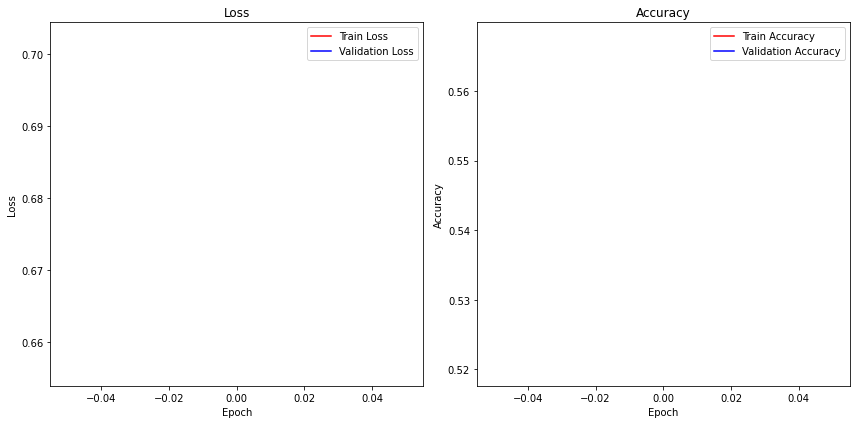

epoch: 1, batch_id: 0, loss is: [0.68762714]
epoch: 1, batch_id: 10, loss is: [1.189676]
epoch: 1, batch_id: 20, loss is: [1.2056937]
epoch: 1, batch_id: 30, loss is: [0.81841785]
[validation] accuracy/loss: 0.7475000023841858/0.562373161315918


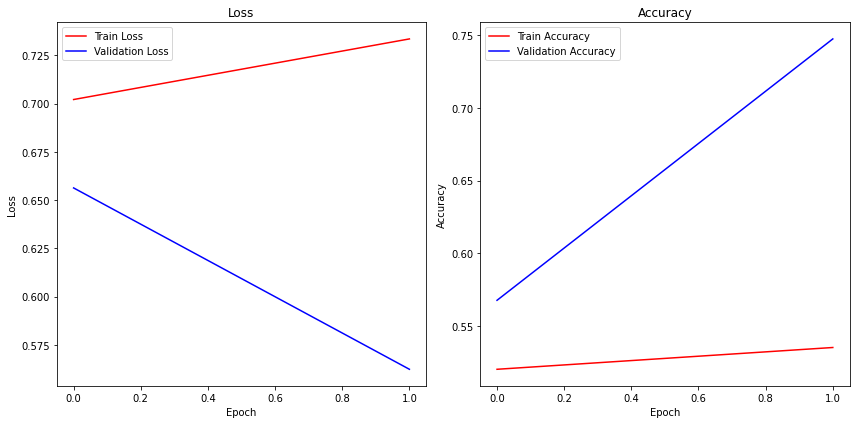

epoch: 2, batch_id: 0, loss is: [0.6714661]
epoch: 2, batch_id: 10, loss is: [0.63526213]
epoch: 2, batch_id: 20, loss is: [0.8069345]
epoch: 2, batch_id: 30, loss is: [0.5194423]
[validation] accuracy/loss: 0.7150000333786011/0.4829385280609131


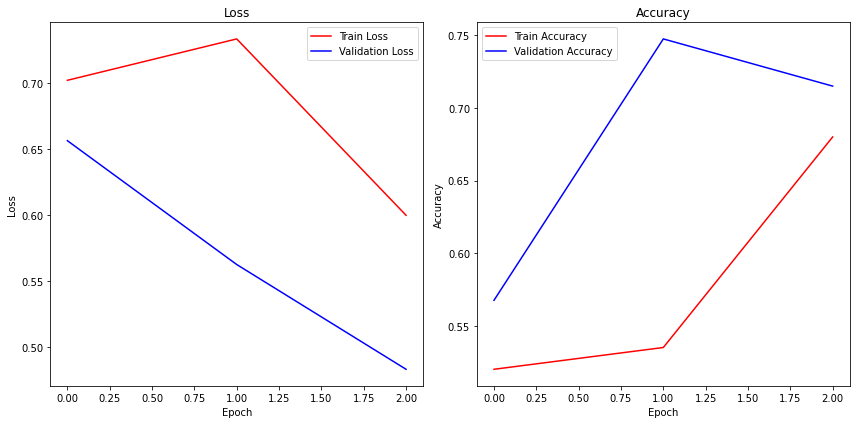

epoch: 3, batch_id: 0, loss is: [0.6460332]
epoch: 3, batch_id: 10, loss is: [0.37646866]
epoch: 3, batch_id: 20, loss is: [0.4178396]
epoch: 3, batch_id: 30, loss is: [0.34542835]
[validation] accuracy/loss: 0.8774999380111694/0.3161563575267792


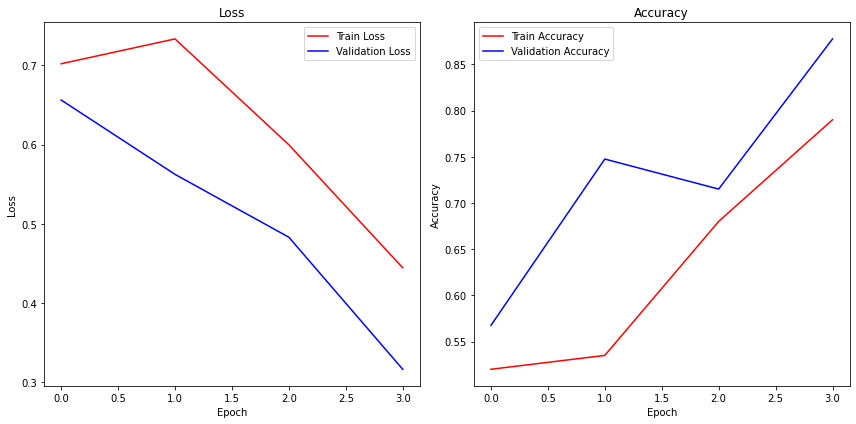

epoch: 4, batch_id: 0, loss is: [0.40228277]
epoch: 4, batch_id: 10, loss is: [0.29840553]
epoch: 4, batch_id: 20, loss is: [0.40574753]
epoch: 4, batch_id: 30, loss is: [0.5852828]
[validation] accuracy/loss: 0.9449999928474426/0.205620676279068


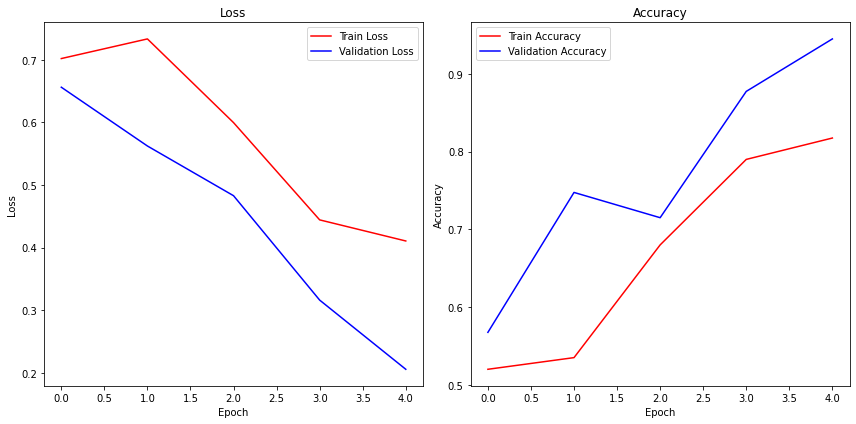

epoch: 5, batch_id: 0, loss is: [0.1843147]
epoch: 5, batch_id: 10, loss is: [0.43050152]
epoch: 5, batch_id: 20, loss is: [0.38974676]
epoch: 5, batch_id: 30, loss is: [0.4145102]
[validation] accuracy/loss: 0.8174999356269836/0.41214579343795776


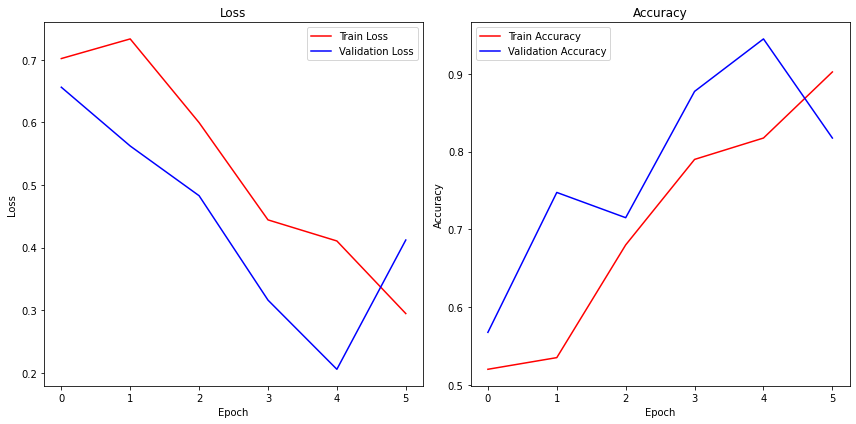

epoch: 6, batch_id: 0, loss is: [0.25898093]
epoch: 6, batch_id: 10, loss is: [0.09061877]
epoch: 6, batch_id: 20, loss is: [0.34672454]
epoch: 6, batch_id: 30, loss is: [0.6018824]
[validation] accuracy/loss: 0.9174998998641968/0.20979972183704376


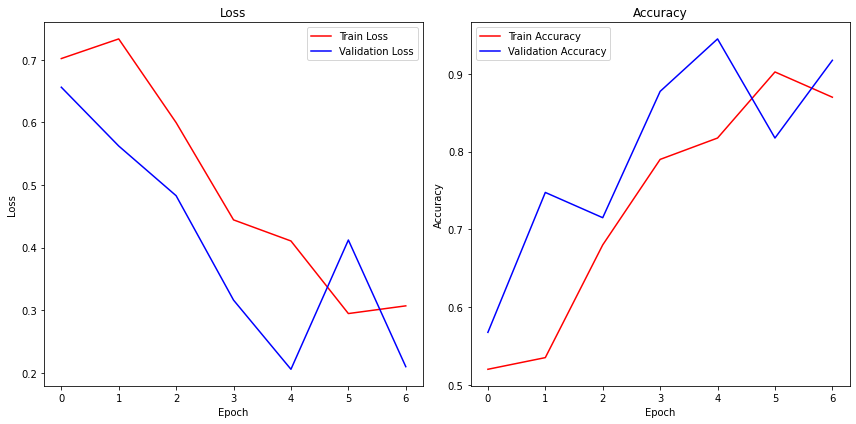

epoch: 7, batch_id: 0, loss is: [0.25040644]
epoch: 7, batch_id: 10, loss is: [0.45349035]
epoch: 7, batch_id: 20, loss is: [0.13682726]
epoch: 7, batch_id: 30, loss is: [0.36658043]
[validation] accuracy/loss: 0.949999988079071/0.15939995646476746


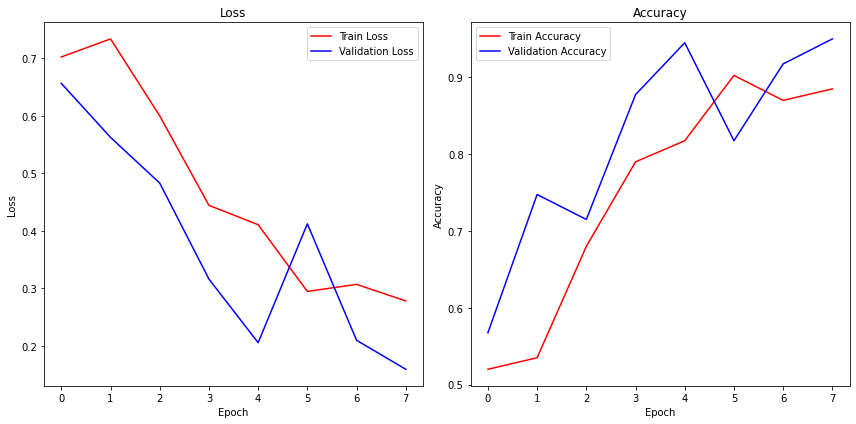

epoch: 8, batch_id: 0, loss is: [0.09585501]
epoch: 8, batch_id: 10, loss is: [0.08823696]
epoch: 8, batch_id: 20, loss is: [0.8428025]
epoch: 8, batch_id: 30, loss is: [0.19080213]
[validation] accuracy/loss: 0.9199999570846558/0.18692228198051453


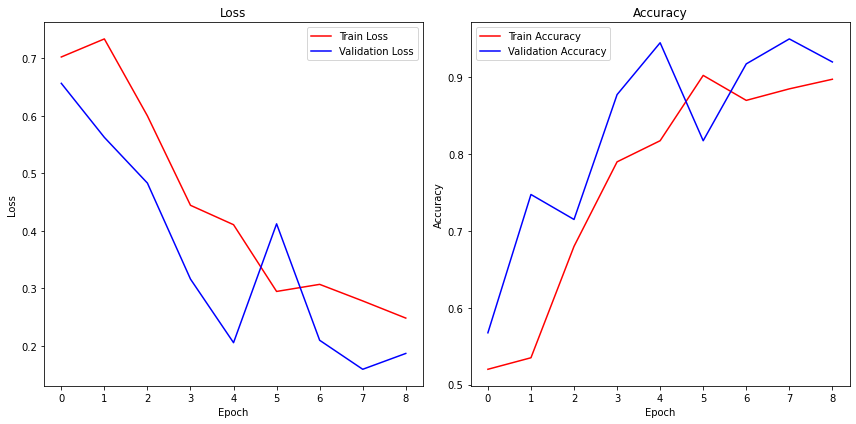

epoch: 9, batch_id: 0, loss is: [0.10503864]
epoch: 9, batch_id: 10, loss is: [0.14595741]
epoch: 9, batch_id: 20, loss is: [0.06372881]
epoch: 9, batch_id: 30, loss is: [0.07453173]
[validation] accuracy/loss: 0.9575001001358032/0.1254279464483261


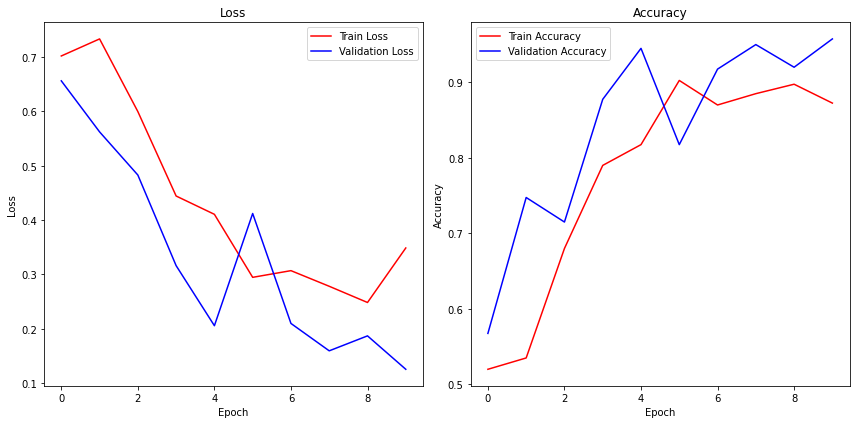

epoch: 10, batch_id: 0, loss is: [0.09835012]
epoch: 10, batch_id: 10, loss is: [0.8282997]
epoch: 10, batch_id: 20, loss is: [0.15166405]
epoch: 10, batch_id: 30, loss is: [0.22497122]
[validation] accuracy/loss: 0.9350000619888306/0.16572074592113495


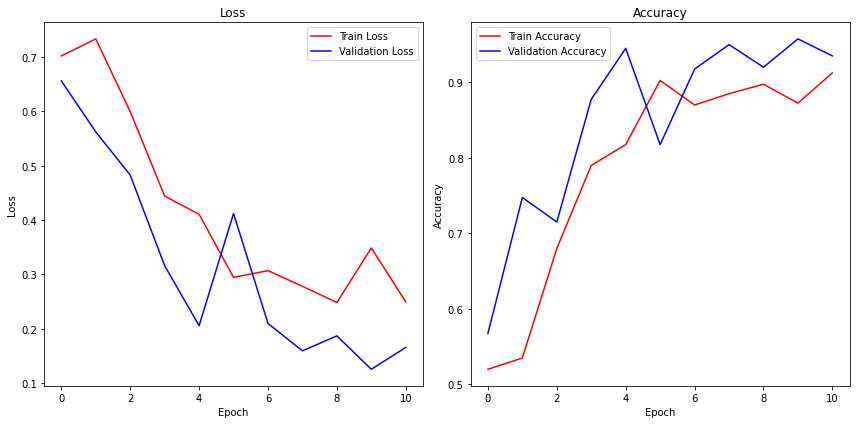

epoch: 11, batch_id: 0, loss is: [0.15404883]
epoch: 11, batch_id: 10, loss is: [0.08620063]
epoch: 11, batch_id: 20, loss is: [0.21296582]
epoch: 11, batch_id: 30, loss is: [0.11398198]
[validation] accuracy/loss: 0.934999942779541/0.178155779838562


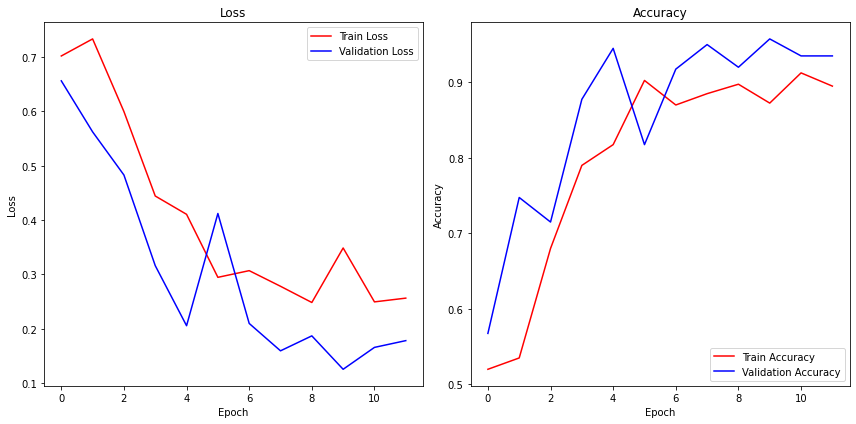

epoch: 12, batch_id: 0, loss is: [0.25605786]
epoch: 12, batch_id: 10, loss is: [0.29505888]
epoch: 12, batch_id: 20, loss is: [0.49164945]
epoch: 12, batch_id: 30, loss is: [0.04586303]
[validation] accuracy/loss: 0.9299999475479126/0.1644057333469391


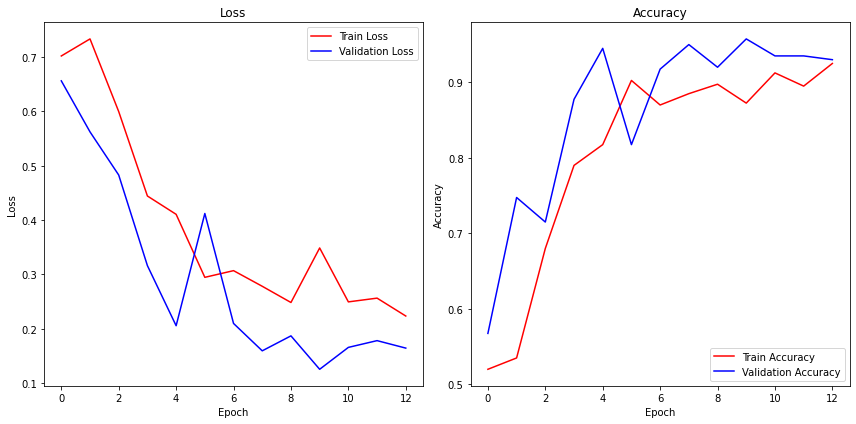

epoch: 13, batch_id: 0, loss is: [0.12611586]
epoch: 13, batch_id: 10, loss is: [0.13718866]
epoch: 13, batch_id: 20, loss is: [0.16836388]
epoch: 13, batch_id: 30, loss is: [0.4580196]
[validation] accuracy/loss: 0.9574999809265137/0.14686088263988495


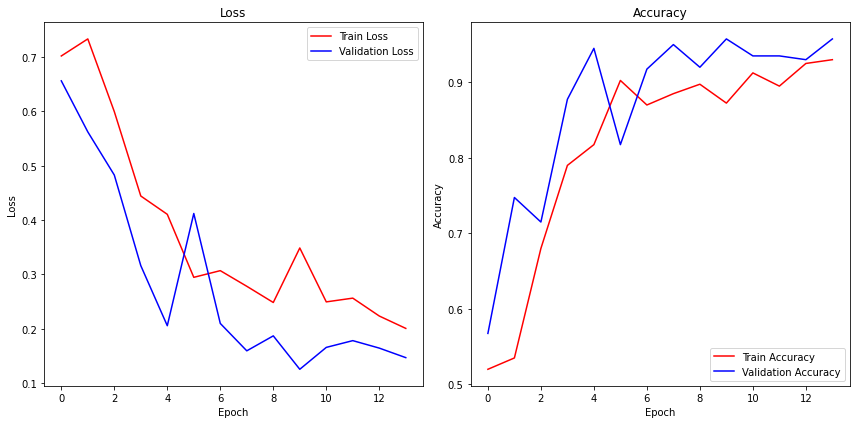

epoch: 14, batch_id: 0, loss is: [0.23493527]
epoch: 14, batch_id: 10, loss is: [0.38605136]
epoch: 14, batch_id: 20, loss is: [0.09395422]
epoch: 14, batch_id: 30, loss is: [0.31669062]
[validation] accuracy/loss: 0.9424999952316284/0.18970756232738495


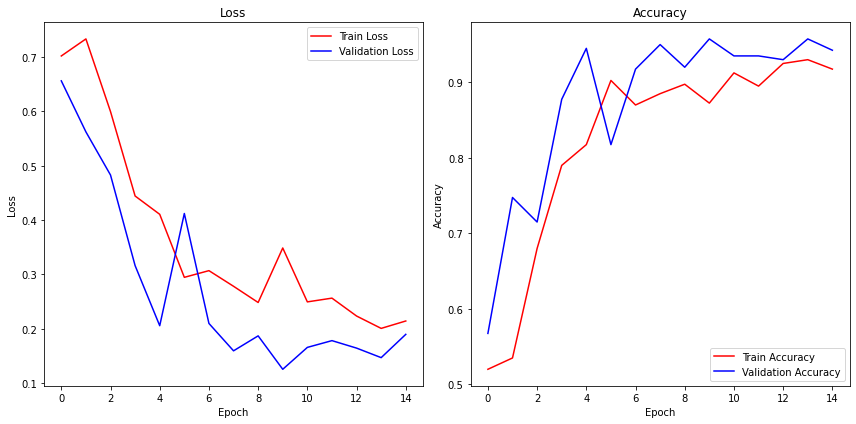

epoch: 15, batch_id: 0, loss is: [0.10178737]
epoch: 15, batch_id: 10, loss is: [0.31126827]
epoch: 15, batch_id: 20, loss is: [0.01838313]
epoch: 15, batch_id: 30, loss is: [0.9161843]
[validation] accuracy/loss: 0.9299999475479126/0.18525414168834686


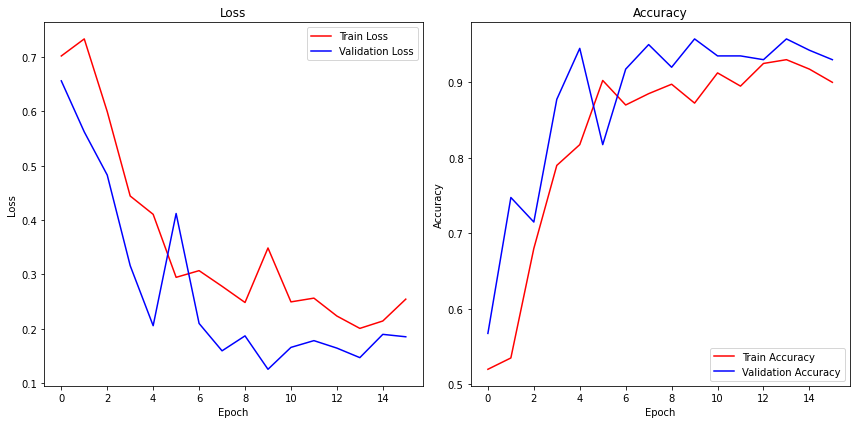

epoch: 16, batch_id: 0, loss is: [0.88463557]
epoch: 16, batch_id: 10, loss is: [0.49097782]
epoch: 16, batch_id: 20, loss is: [0.13927487]
epoch: 16, batch_id: 30, loss is: [0.2167577]
[validation] accuracy/loss: 0.8799999356269836/0.26193591952323914


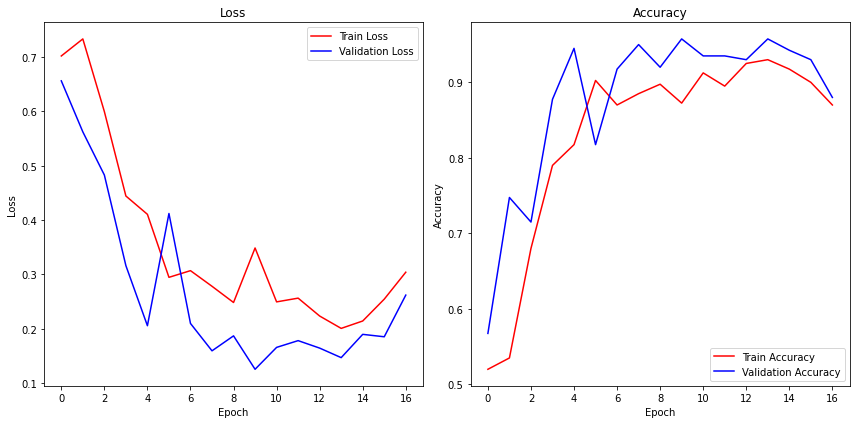

epoch: 17, batch_id: 0, loss is: [0.21615952]
epoch: 17, batch_id: 10, loss is: [0.08904298]
epoch: 17, batch_id: 20, loss is: [0.15123643]
epoch: 17, batch_id: 30, loss is: [0.05575908]
[validation] accuracy/loss: 0.949999988079071/0.13596856594085693


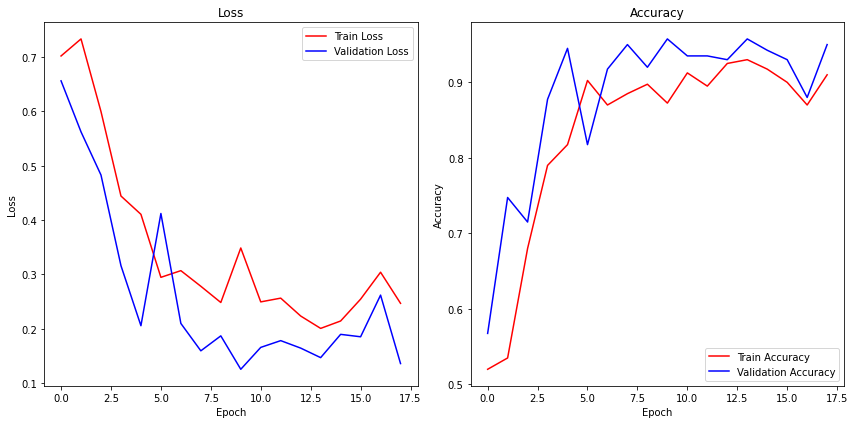

epoch: 18, batch_id: 0, loss is: [0.07362705]
epoch: 18, batch_id: 10, loss is: [0.1467443]
epoch: 18, batch_id: 20, loss is: [0.5967117]
epoch: 18, batch_id: 30, loss is: [0.07768809]
[validation] accuracy/loss: 0.9225000143051147/0.3388911783695221


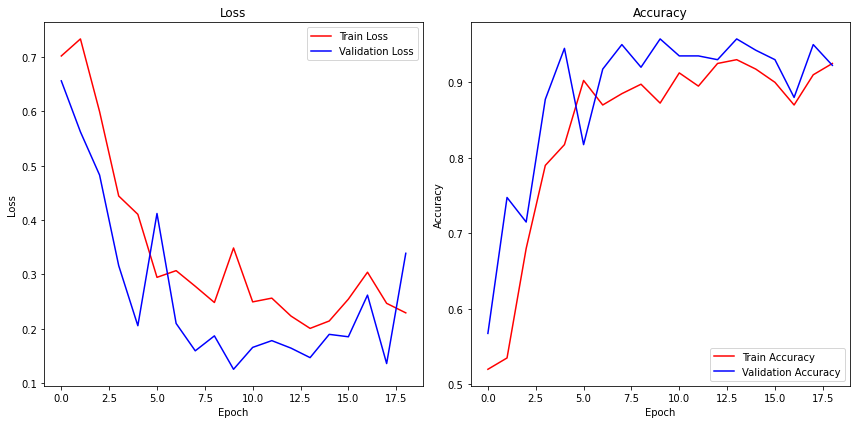

epoch: 19, batch_id: 0, loss is: [0.03787436]
epoch: 19, batch_id: 10, loss is: [0.02833038]
epoch: 19, batch_id: 20, loss is: [0.02921961]
epoch: 19, batch_id: 30, loss is: [0.09362089]
[validation] accuracy/loss: 0.9475000500679016/0.17581254243850708


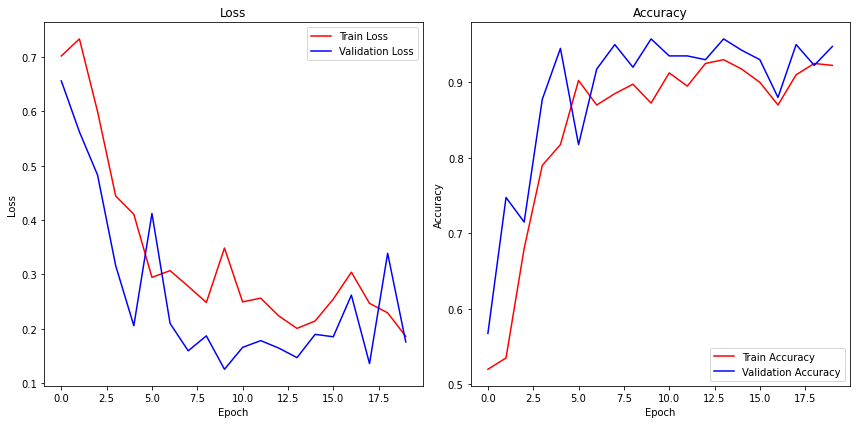

In [43]:

# 定义训练过程
def train(model):
    with fluid.dygraph.guard():
        print('start training ... ')
        model.train()
        epoch_num = 20
        iter=0
        # 定义优化器
        opt = fluid.optimizer.Momentum(learning_rate=0.0005, momentum=0.9, parameter_list=model.parameters())
        # 定义数据读取器，训练数据读取器和验证数据读取器
        train_loader = data_loader(DATADIR, batch_size=10, mode='train')
        valid_loader = valid_data_loader(DATADIR2, CSVFILE)
        with LogWriter(logdir="./log/scalar_test/train1") as writer:
            
            for epoch in range(epoch_num):
                x.append(epoch)
                train_accuracies = []
                train_loss = []
                for batch_id, data in enumerate(train_loader()):
                    x_data, y_data = data
                    img = fluid.dygraph.to_variable(x_data)
                    label = fluid.dygraph.to_variable(y_data)
                    # 运行模型前向计算，得到预测值
                    global llll
                    logits,conv = model(img)
                    llll = logits
                    pred = fluid.layers.sigmoid(logits)
                    pred2 = pred * (-1.0) + 1.0
                    pred = fluid.layers.concat([pred2, pred], axis=1)
                    #计算accuracy
                    acc = fluid.layers.accuracy(pred, fluid.layers.cast(label, dtype='int64'))
                    # 进行loss计算
                    loss = fluid.layers.sigmoid_cross_entropy_with_logits(logits, label)
                    avg_loss = fluid.layers.mean(loss)
                    train_accuracies.append(acc.numpy())
                    train_loss.append(loss.numpy())
                    #训练过程中插入作图语句，当每10个batch训练完成后，将当前损失、准确率作为一个新增的数据点储存到记录器中。
                    if batch_id % 10 == 0:
                        iter+=10
                        print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
                    # 反向传播，更新权重，清除梯度
                    avg_loss.backward()
                    opt.minimize(avg_loss)
                    model.clear_gradients()
                train_loss_list.append(np.mean(train_loss))
                train_acc_list.append(np.mean(train_accuracies)) 
                
                model.eval()
                accuracies = []
                losses = []
                for batch_id, data in enumerate(valid_loader()):

                    x_data, y_data = data
                    img = fluid.dygraph.to_variable(x_data)
                    label = fluid.dygraph.to_variable(y_data)
                    # 运行模型前向计算，得到预测值
                    logits,conv = model(img)
                    # 二分类，sigmoid计算后的结果以0.5为阈值分两个类别
                    # 计算sigmoid后的预测概率，进行loss计算
                    pred = fluid.layers.sigmoid(logits)
                    loss = fluid.layers.sigmoid_cross_entropy_with_logits(logits, label)
                    avg_loss = fluid.layers.mean(loss)
                    # 计算预测概率小于0.5的类别
                    pred2 = pred * (-1.0) + 1.0
                    # 得到两个类别的预测概率，并沿第一个维度级联
                    pred = fluid.layers.concat([pred2, pred], axis=1)
                    acc = fluid.layers.accuracy(pred, fluid.layers.cast(label, dtype='int64'))
                    accuracies.append(acc.numpy())
                    losses.append(loss.numpy())
                global see
                see = x_data
                
                writer.add_scalar(tag="acc",step=epoch,value = np.mean(accuracies))
                writer.add_scalar(tag="loss",step=epoch,value = np.mean(losses))
                
                val_loss_list.append(np.mean(losses))
                val_acc_list.append(np.mean(accuracies))
                
                print("[validation] accuracy/loss: {}/{}".format(np.mean(accuracies), np.mean(losses)))
                #print(fluid.layers.cast(label, dtype='int64').numpy())
                model.train()
                plt.figure(figsize=(12, 6))
            
                # Plot loss
                plt.subplot(1, 2, 1)
                plt.plot(x, train_loss_list, 'r', label='Train Loss')
                plt.plot(x, val_loss_list, 'b', label='Validation Loss')
                plt.title("Loss")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.legend()

                # Plot accuracy
                plt.subplot(1, 2, 2)
                plt.plot(x, train_acc_list, 'r', label='Train Accuracy')
                plt.plot(x, val_acc_list, 'b', label='Validation Accuracy')
                plt.title("Accuracy")
                plt.xlabel("Epoch")
                plt.ylabel("Accuracy")
                plt.legend()

                plt.tight_layout()
                plt.show()
                plt.pause(0.1)

        # save params of model
        fluid.save_dygraph(model.state_dict(), 'ResNet')
        # save optimizer state
        fluid.save_dygraph(opt.state_dict(), 'ResNet')
with fluid.dygraph.guard():
    model = ResNet()

mymaodao = train(model)

In [44]:
valid_loader = valid_data_loader(DATADIR2, CSVFILE)
model.eval()
accuracies = []
losses = []
with fluid.dygraph.guard():
    for batch_id, data in enumerate(valid_loader()):
        x_data, y_data = data
        img = fluid.dygraph.to_variable(x_data)
        label = fluid.dygraph.to_variable(y_data)
        # 运行模型前向计算，得到预测值
        logits,conv = model(img)
        pred = fluid.layers.sigmoid(logits)
        loss = fluid.layers.sigmoid_cross_entropy_with_logits(logits, label)
        avg_loss = fluid.layers.mean(loss)
        # 计算预测概率小于0.5的类别
        pred2 = pred * (-1.0) + 1.0
        # 得到两个类别的预测概率，并沿第一个维度级联
        pred = fluid.layers.concat([pred2, pred], axis=1)
        acc = fluid.layers.accuracy(pred, fluid.layers.cast(label, dtype='int64'))
        accuracies.append(acc.numpy())
        losses.append(loss.numpy())

In [45]:
 print("[validation] accuracy/loss: {}/{}".format(np.mean(accuracies), np.mean(losses)))

[validation] accuracy/loss: 0.9475000500679016/0.17581254243850708
